Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0510 - loss: 4.5672 - val_accuracy: 0.2353 - val_loss: 3.5626
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5264 - loss: 2.6240 - val_accuracy: 0.4412 - val_loss: 2.3245
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7702 - loss: 1.2589 - val_accuracy: 0.6275 - val_loss: 1.6369
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9239 - loss: 0.6210 - val_accuracy: 0.6961 - val_loss: 1.4155
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9724 - loss: 0.3256 - val_accuracy: 0.6961 - val_loss: 1.2865


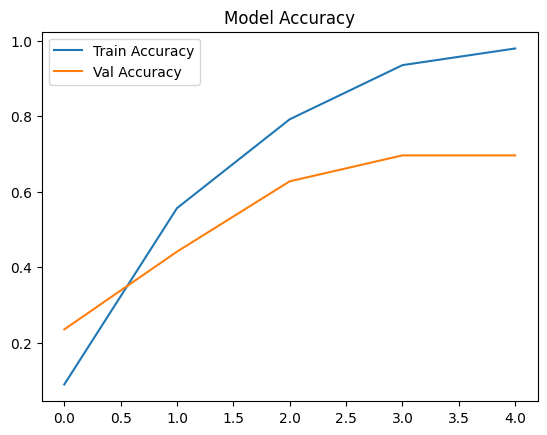

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

# Preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = ds_train.map(format_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Number of classes
num_classes = ds_info.features['label'].num_classes

# Build model using MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# Save
model.save('flowers102_model.h5')

# Accuracy & Loss Plots
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()


In [15]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
import tensorflow_datasets as tfds

# Load model
model = tf.keras.models.load_model('flowers102_model.h5')

# Get class names
class_names = tfds.builder('oxford_flowers102').info.features['label'].names

st.title("🌸 Oxford Flower Classifier 🌸")
st.write("Upload a flower image, and this app will tell you its type!")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).resize((224, 224))
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    st.markdown(f"### Prediction: **{class_names[predicted_index]}**")
    st.markdown(f"### Confidence: **{confidence * 100:.2f}%**")

    # Top 3
    st.markdown("### Top 3 Predictions:")
    top3 = np.argsort(predictions[0])[::-1][:3]
    for i in top3:
        st.write(f"{class_names[i]}: {predictions[0][i] * 100:.2f}%")


2025-08-05 11:10:30.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-05 11:10:30.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-05 11:10:30.429 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-05 11:10:30.431 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-05 11:10:30.432 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-05 11:10:30.433 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-05 11:10:30.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-05 11:10:30.435 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [13]:
!pip install streamlit pyngrok


In [23]:
%%writefile app.py
import streamlit as st
import torch
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO

# Title and instructions
st.title("🏛️ Architecture Classifier")
st.write("Upload an image of a building or structure to classify its architectural style.")

# Load pre-trained model
model = models.resnet18(pretrained=True)
model.eval()

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load labels (ImageNet labels)
@st.cache_data
def load_labels():
    response = requests.get("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt")
    return response.text.strip().split("\n")

labels = load_labels()

# File uploader
uploaded_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

# Inference and result display
if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess image
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    with st.spinner("Classifying..."):
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            top5_prob, top5_catid = torch.topk(probabilities, 5)

        # Display results
        st.subheader("Top Predictions:")
        for i in range(top5_prob.size(0)):
            st.write(f"**{labels[top5_catid[i]]}** : {top5_prob[i].item()*100:.2f}%")


Overwriting app.py


In [24]:
from pyngrok import ngrok

# Set auth token if you haven’t already
ngrok.set_auth_token("30MfqGAoMtxXK5r9RsPJrpLmq13_6tAvWAGYX8XddJAhJDpSf")

# Correct usage: expose Streamlit on port 8501
public_url = ngrok.connect(addr=8501, proto="http")
print("Streamlit app running at:", public_url)


Streamlit app running at: NgrokTunnel: "https://eaebea8ff5bd.ngrok-free.app" -> "http://localhost:8501"
